<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/S10-Assignment/S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/content/gdrive/My Drive/S10-Assignment/')
!ls /content/gdrive/My\ Drive/S10-Assignment

dataloader.py	    grad_cam.py   misclassified.py  Transforms_Albumentations
data_transforms.py  __init__.py   Models	    utils.py
eval.py		    lr_finder.py  README.md


In [3]:
%cd /content/gdrive/My Drive/S10-Assignment/

/content/gdrive/My Drive/S10-Assignment


In [4]:
!ls

dataloader.py	    grad_cam.py   misclassified.py  Transforms_Albumentations
data_transforms.py  __init__.py   Models	    utils.py
eval.py		    lr_finder.py  README.md


In [5]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
!pip install albumentations

     |████████████████████████████████| 634kB 2.7MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=e3dd6000cfb7746b0c43d62ad58fdae219f7e8a499e48ec0f2fcdf7e818f7cd4
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [6]:
from Transforms_Albumentations import transform

import importlib
importlib.reload(transform)

#from transform  import Data
data = transform.Data()

trainset = data.getTrainDataSet(train=True)
testset =  data.getTrainDataSet(train=False)
trainloader = data.getDataLoader(trainset, 128)
show_trainloader = data.getDataLoader(trainset, 4)
testloader = data.getDataLoader(testset, 128)
show_testloader = data.getDataLoader(testset, 4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   cat   dog plane


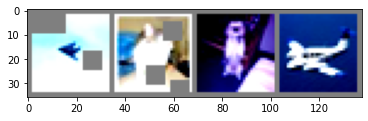

In [8]:
# functions to show an image
import utils

# get some random training images
dataiter = iter(show_trainloader)
pics, labels = dataiter.next()

# show images
utils.imshow(torchvision.utils.make_grid(pics))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
#from models import resnet
from Models import resnet

import torch

import importlib
importlib.reload(resnet)


model = resnet.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
print(model.device)
model = model.to(model.device)
model.summary((3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


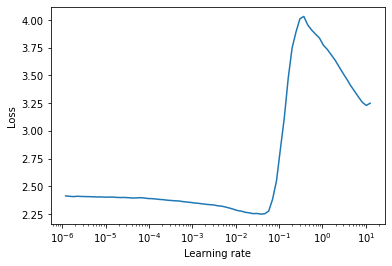

In [18]:

from lr_finder import LRFinder

import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import StepLR


EPOCHS = 50
l2_loss = 0.0001
l1_lambda = 0
criterion = nn.CrossEntropyLoss()

#Optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=l2_loss)

#LR Finder
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()


In [19]:
#Find the min loss from lr finder
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
print(min(loss))
print(lr[loss.index(min(loss))])
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=l2_loss)

2.248526563494083
0.03801893963205612


Create schedular and evaulate the model

In [20]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ReduceLROnPlateau
schedular = ReduceLROnPlateau(optimizer, min_lr=1e-7, patience = 4)
model.evaluate(optimizer, trainloader, testloader, EPOCHS, criterion, schedular, False, l1_lambda)


Epoch= 0 Loss=0.9377008676528931 Batch_id=390 Accuracy=81.25: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 0, Train Accuracy: 81.25 , Test Accuracy: 63.07


Epoch= 1 Loss=1.075244665145874 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1, Train Accuracy: 78.75 , Test Accuracy: 70.61


Epoch= 2 Loss=0.42000263929367065 Batch_id=390 Accuracy=93.75: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2, Train Accuracy: 93.75 , Test Accuracy: 75.18


Epoch= 3 Loss=0.7054092288017273 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3, Train Accuracy: 88.75 , Test Accuracy: 78.15


Epoch= 4 Loss=0.594697117805481 Batch_id=390 Accuracy=96.25: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4, Train Accuracy: 96.25 , Test Accuracy: 81.01


Epoch= 5 Loss=0.41516128182411194 Batch_id=390 Accuracy=93.75: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5, Train Accuracy: 93.75 , Test Accuracy: 80.97


Epoch= 6 Loss=0.35850462317466736 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6, Train Accuracy: 97.5 , Test Accuracy: 81.58


Epoch= 7 Loss=0.18790605664253235 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7, Train Accuracy: 98.75 , Test Accuracy: 83.01


Epoch= 8 Loss=0.24153847992420197 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8, Train Accuracy: 100.0 , Test Accuracy: 82.32


Epoch= 9 Loss=0.5246736407279968 Batch_id=390 Accuracy=95.00: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9, Train Accuracy: 95.0 , Test Accuracy: 83.89


Epoch= 10 Loss=0.20316942036151886 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10, Train Accuracy: 98.75 , Test Accuracy: 84.15


Epoch= 11 Loss=0.18311992287635803 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11, Train Accuracy: 100.0 , Test Accuracy: 84.14


Epoch= 12 Loss=0.15465566515922546 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12, Train Accuracy: 100.0 , Test Accuracy: 81.9


Epoch= 13 Loss=0.16720286011695862 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13, Train Accuracy: 98.75 , Test Accuracy: 84.63


Epoch= 14 Loss=0.08869180828332901 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14, Train Accuracy: 97.5 , Test Accuracy: 87.59


Epoch= 15 Loss=0.06304137408733368 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15, Train Accuracy: 98.75 , Test Accuracy: 88.01


Epoch= 16 Loss=0.03259178251028061 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16, Train Accuracy: 100.0 , Test Accuracy: 87.98


Epoch= 17 Loss=0.10535478591918945 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17, Train Accuracy: 97.5 , Test Accuracy: 88.42


Epoch= 18 Loss=0.051420312374830246 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18, Train Accuracy: 98.75 , Test Accuracy: 88.34


Epoch= 19 Loss=0.04795936495065689 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19, Train Accuracy: 98.75 , Test Accuracy: 88.25


Epoch= 20 Loss=0.02120879665017128 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20, Train Accuracy: 100.0 , Test Accuracy: 88.21


Epoch= 21 Loss=0.10918530076742172 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21, Train Accuracy: 97.5 , Test Accuracy: 88.42


Epoch= 22 Loss=0.05078594759106636 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22, Train Accuracy: 98.75 , Test Accuracy: 88.55


Epoch= 23 Loss=0.0588449127972126 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23, Train Accuracy: 97.5 , Test Accuracy: 88.43


Epoch= 24 Loss=0.07487758994102478 Batch_id=390 Accuracy=96.25: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24, Train Accuracy: 96.25 , Test Accuracy: 88.56


Epoch= 25 Loss=0.02216198667883873 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25, Train Accuracy: 100.0 , Test Accuracy: 88.23


Epoch= 26 Loss=0.030802637338638306 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26, Train Accuracy: 100.0 , Test Accuracy: 88.37


Epoch= 27 Loss=0.07661418616771698 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27, Train Accuracy: 97.5 , Test Accuracy: 88.48


Epoch= 28 Loss=0.045525044202804565 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28, Train Accuracy: 98.75 , Test Accuracy: 88.31


Epoch= 29 Loss=0.03401607647538185 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29, Train Accuracy: 98.75 , Test Accuracy: 88.64


Epoch= 30 Loss=0.055029284209012985 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30, Train Accuracy: 98.75 , Test Accuracy: 88.43


Epoch= 31 Loss=0.07970567047595978 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31, Train Accuracy: 97.5 , Test Accuracy: 88.14


Epoch= 32 Loss=0.08485919237136841 Batch_id=390 Accuracy=96.25: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32, Train Accuracy: 96.25 , Test Accuracy: 88.25


Epoch= 33 Loss=0.008959973230957985 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33, Train Accuracy: 100.0 , Test Accuracy: 88.17


Epoch= 34 Loss=0.0310012549161911 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34, Train Accuracy: 98.75 , Test Accuracy: 88.35


Epoch= 35 Loss=0.017112310975790024 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35, Train Accuracy: 100.0 , Test Accuracy: 88.31


Epoch= 36 Loss=0.05728617310523987 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36, Train Accuracy: 98.75 , Test Accuracy: 88.81


Epoch= 37 Loss=0.06622729450464249 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37, Train Accuracy: 98.75 , Test Accuracy: 88.63


Epoch= 38 Loss=0.02461942471563816 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38, Train Accuracy: 100.0 , Test Accuracy: 88.5


Epoch= 39 Loss=0.10781097412109375 Batch_id=390 Accuracy=96.25: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39, Train Accuracy: 96.25 , Test Accuracy: 88.74


Epoch= 40 Loss=0.016060061752796173 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40, Train Accuracy: 100.0 , Test Accuracy: 88.43


Epoch= 41 Loss=0.011006874963641167 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41, Train Accuracy: 100.0 , Test Accuracy: 88.62


Epoch= 42 Loss=0.026898633688688278 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42, Train Accuracy: 98.75 , Test Accuracy: 88.52


Epoch= 43 Loss=0.09655440598726273 Batch_id=390 Accuracy=96.25: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43, Train Accuracy: 96.25 , Test Accuracy: 88.2


Epoch= 44 Loss=0.04561171680688858 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44, Train Accuracy: 97.5 , Test Accuracy: 88.48


Epoch= 45 Loss=0.04734998568892479 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45, Train Accuracy: 98.75 , Test Accuracy: 88.34


Epoch= 46 Loss=0.03185506910085678 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46, Train Accuracy: 98.75 , Test Accuracy: 88.65


Epoch= 47 Loss=0.02282244898378849 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47, Train Accuracy: 100.0 , Test Accuracy: 88.47


Epoch= 48 Loss=0.009187094867229462 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:40<00:00,  9.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48, Train Accuracy: 100.0 , Test Accuracy: 88.57


Epoch= 49 Loss=0.033323537558317184 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
100%|██████████| 79/79 [00:03<00:00, 20.45it/s]

Epoch 49, Train Accuracy: 98.75 , Test Accuracy: 88.77


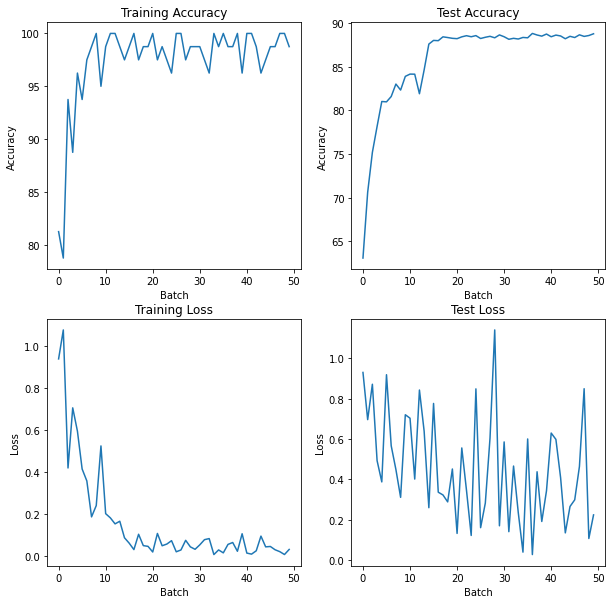

In [21]:
#Plot the graph
model.trainer.plot_graph()

GradCam and misclassfied images

Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


saliency_map size : torch.Size([8, 8])
<class 'torch.Tensor'>


<class 'torch.Tensor'>
<class 'torch.Tensor'>


<class 'torch.Tensor'>
<class 'torch.Tensor'>


<class 'torch.Tensor'>
<class 'torch.Tensor'>


<class 'torch.Tensor'>
<class 'torch.Tensor'>


<class 'torch.Tensor'>


<class 'torch.Tensor'>
<class 'torch.Tensor'>


<class 'torch.Tensor'>


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


<class 'torch.Tensor'>
<class 'torch.Tensor'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


<class 'torch.Tensor'>
<class 'torch.Tensor'>


<class 'torch.Tensor'>
<class 'torch.Tensor'>


<class 'torch.Tensor'>


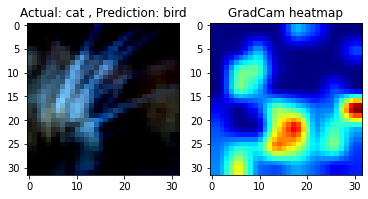

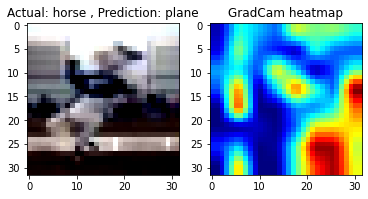

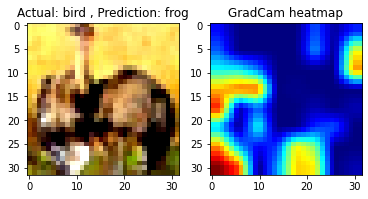

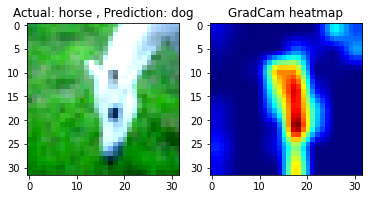

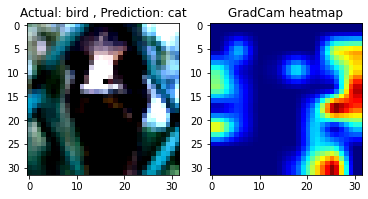

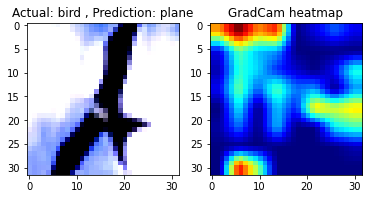

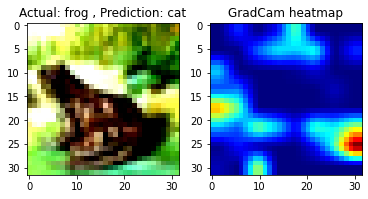

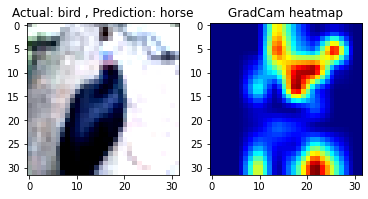

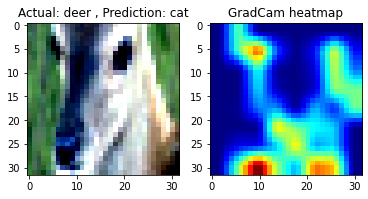

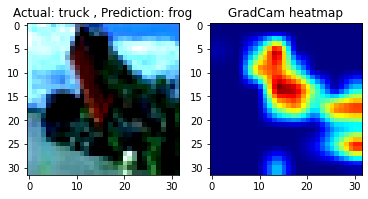

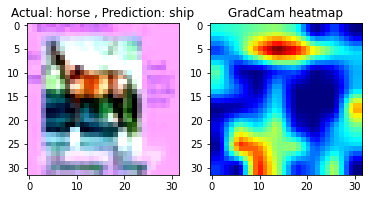

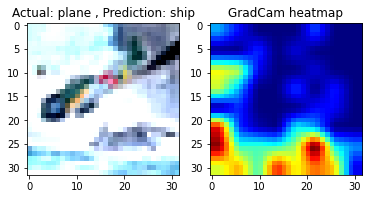

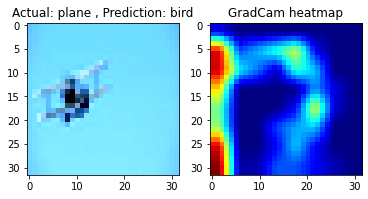

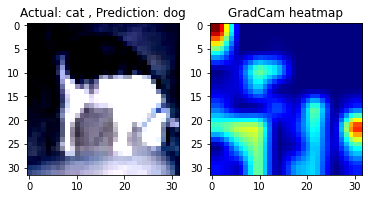

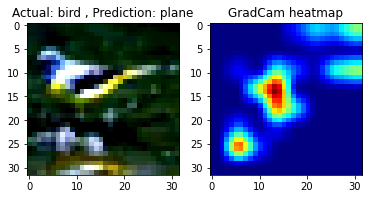

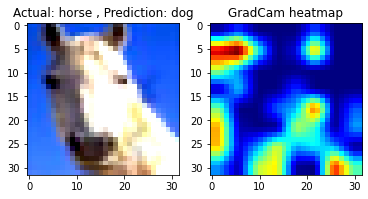

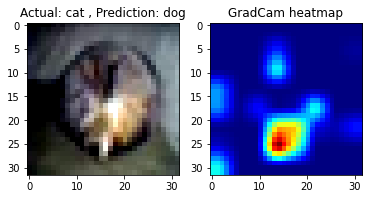

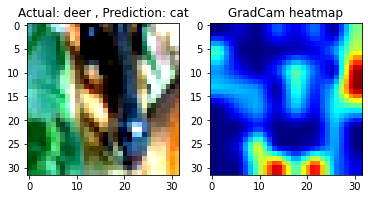

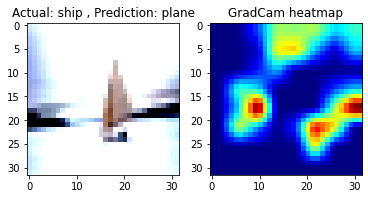

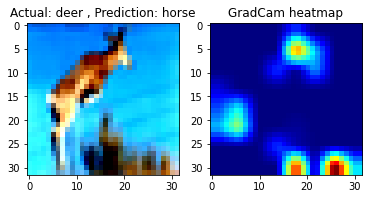

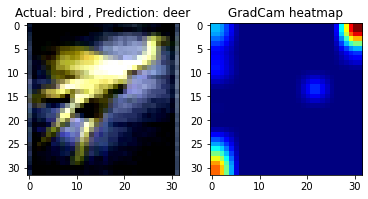

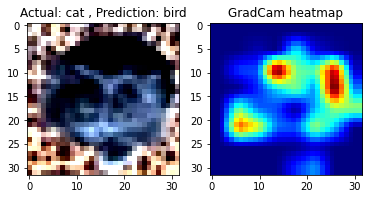

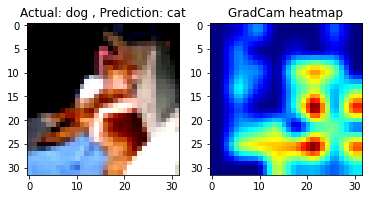

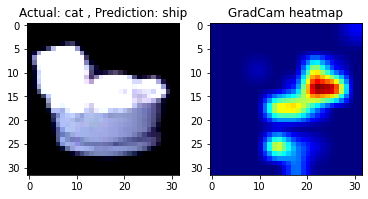

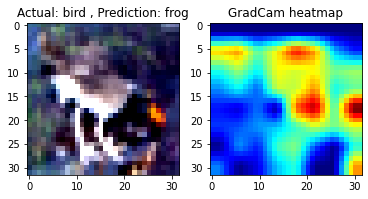

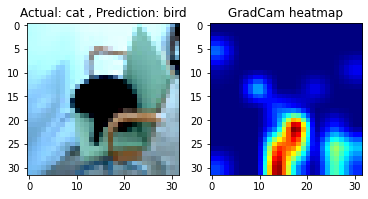

In [22]:
import cv2
import numpy as np
import torch
from torchvision.utils import make_grid
import torch.nn.functional as F
import utils

testset =  data.getTestDataSet(train=False)
testloader2 = data.getGradCamDataLoader(testset)

dataiter = iter(testloader2)
pic, labels = dataiter.next()
#print(model.layer4)
from grad_cam import GradCAM

resnet_dict = dict(type='resnet', arch=model, target_layer=model.layer3, input_size=(32, 32))
gradcam = GradCAM(resnet_dict, True)


index = 0
while(index <= 25):
    images, labels = dataiter.next()
    output = model(images.cuda())
    pred = output.argmax(dim=1, keepdim=True)
    if(classes[pred] != classes[labels]):
      fig, axes = plt.subplots(nrows=1, ncols=2)
      mask, _ = gradcam(images.to(model.device))
      mask = mask.cpu()

      axes[0].set_title("Actual: "+str(classes[labels])+" , Prediction: "+str(classes[pred]))
      axes[1].set_title("GradCam heatmap")

      images = torchvision.utils.make_grid(images)
      heatmap, result = utils.visualize_cam(mask.numpy(), images.numpy())

      axes[1].imshow(np.transpose(heatmap, (1, 2, 0)))
      im = torchvision.utils.make_grid(images)
      im = im / 2 + 0.5     # unnormalize
      img = im.numpy()
      axes[0].imshow(np.transpose(img, (1, 2, 0)))

      index=index+1
